In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt
from pyproj import Transformer

from uavsar_pytools.snow_depth_inversion import phase_from_depth, depth_from_phase

data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')

In [2]:
data_dir = Path('/bsuhome/zacharykeskinen/uavsar-validation/data')
insitu_dir = data_dir.joinpath('insitu')
insitu = pd.read_parquet(insitu_dir.joinpath('all_difference.parq'))
insitu = insitu[insitu.site_name != 'jackson']
insitu = gpd.GeoDataFrame(insitu, geometry=gpd.points_from_xy(insitu.lon, insitu.lat), crs="EPSG:4326")

In [28]:
ds = xr.open_dataset(ncs_dir.joinpath('tmp_uv_geom_atm_veg_model_v2.nc')).isel(x = slice(0, -1, 100), y = slice(0, -1, 100))
ds['delay'] = ds.delay.where((ds.delay > ds.delay.quantile(0.01)) & (ds.delay < ds.delay.quantile(0.99)))
ds = ds.sortby('time1')
ds = ds.sortby('time')

ds['unw_atm'] = ds['unw'] - ds['delay']
ds['int_atm'] = ds['int_phase'] - ds['delay']

inc_mean = ds['inc'].mean()

snotels = insitu[insitu.datasource == 'NRCS']

for t1 in insitu.time1.unique():
    print(t1)
    insitu_time = snotels[snotels.time1 == t1]
    # correct by SD
    insitu_density = pd.concat([insitu_time['t1_density'], insitu_time['t2_density']]).mean()
    insitu_dSWE = insitu_time['dSWE'].mean()
    expected_phase = phase_from_depth(insitu_dSWE * insitu_density / 997, inc_angle = inc_mean, density = insitu_density)

    t2 = insitu_time.iloc[0]['time2']
    snow_on = (ds['model_swe'].sel(time = t1) > 0.1) & (ds['model_swe'].sel(time = t2) > 0.1)
    snow_cor = (snow_on & (ds['cor'].sel(time1 = t1) > 0.35))
    for k in ['unw', 'int_phase','unw_atm','int_atm']:
        cur_phase = ds[k].sel(time1 = t1).where(snow_cor).mean()
        print(expected_phase.values)
        print(cur_phase.values)
        ds[k].loc[{'time1':t1}] = ds[k].sel(time1 = t1) - (cur_phase - expected_phase)
        print(ds[k].sel(time1 = t1).where(snow_cor).mean().values)

2020-02-13 20:48:00
0.15646094282649783
-0.17040477475974536
0.15646094282649783
0.15646094282649783
-0.14777590613068398
0.1564609428264979
0.15646094282649783
0.18350254437855043
0.15646094282649786
0.15646094282649783
0.1840225492982847
0.15646094282649786
2021-01-15 19:51:00
0.012053916837347628
-0.7796502267292551
0.01205391683734764
0.012053916837347628
-0.7469390281878727
0.012053916837347623
0.012053916837347628
0.09416614994517811
0.012053916837347637
0.012053916837347628
0.11926037844293208
0.012053916837347642
2021-01-20 21:21:00
0.02185715110498945
-0.15631886757458738
0.02185715110498947
0.02185715110498945
-0.11535670986397092
0.021857151104989446
0.02185715110498945
-1.4938817894146543
0.021857151104989255
0.02185715110498945
-1.4943831215480916
0.021857151104989394
2021-01-27 23:55:00
0.2925423412773127
1.7019910592820915
0.29254234127731266
0.2925423412773127
0.9277464931747442
0.2925423412773127
0.2925423412773127
1.7642918280577327
0.2925423412773127
0.29254234127731

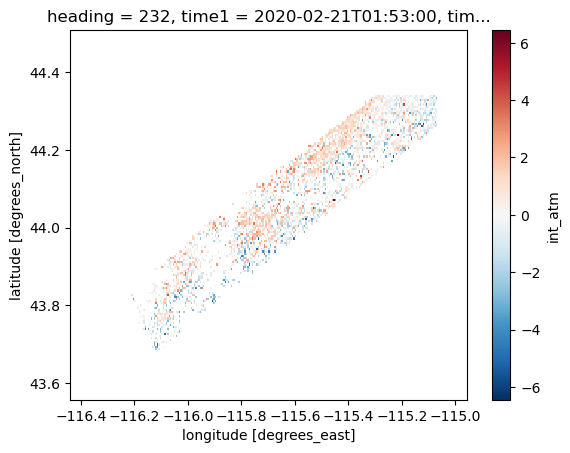

In [30]:
ds[k].sel(time1 = t1).where(snow_cor).plot()